In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scatter_extract
from tensorbox.utils.annolist import AnnotationLib as al
import cv2
import numpy as np
from IPython.display import display, HTML

### Initializating the object dection models:

In [2]:
model_dict = {'ticks':"./output/ticks_v1", "labels":"./output/labels_v1","points":"./output/points_v1"}
iteration = 125000

plt_xtr  = scatter_extract.PlotExtractor(model_dict, iteration)

### Parsing idl files containing ground truth

In [3]:
true_idl_dict = {'ticks':"./data/plot_test/ticks.idl", 
                 "labels":"./data/plot_test/labels.idl","points":"./data/plot_test/points.idl"}

true_annos_dict = {key:al.parse(true_idl_dict[key]) for key in true_idl_dict}

#For the purpose of this notebook we only focus on the first 10 images
true_annos_dict = {key: true_annos_dict[key][0:10] for key in true_annos_dict} 

### Getting prediction bounding boxes for the relevant plot objects

In [4]:
pred_dict = {}
for key in plt_xtr.models:
    pred_dict[key] = plt_xtr.predict_model(plt_xtr.models[key], plt_xtr.H[key], true_annos_dict[key],
                                           "./data/plot_test/", 0.3)

### Drawing images with the true and predicted bounding boxes

images/1.png


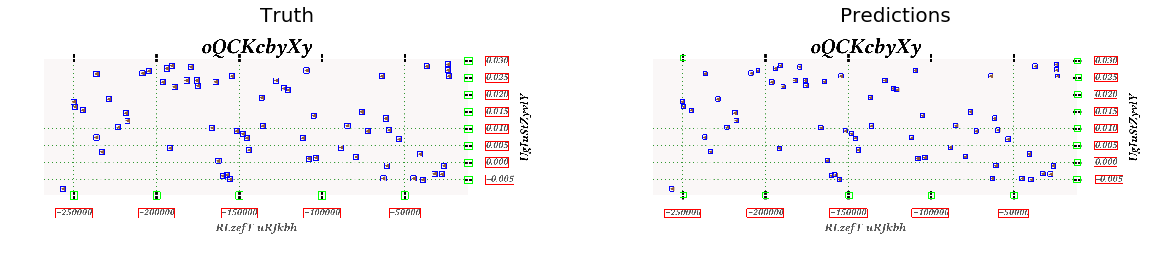

images/2.png


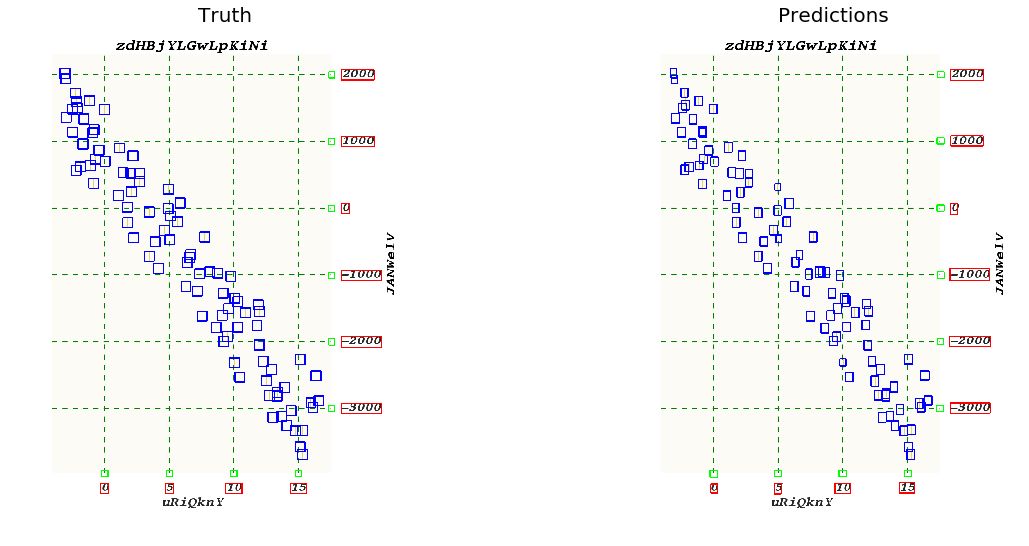

images/3.png


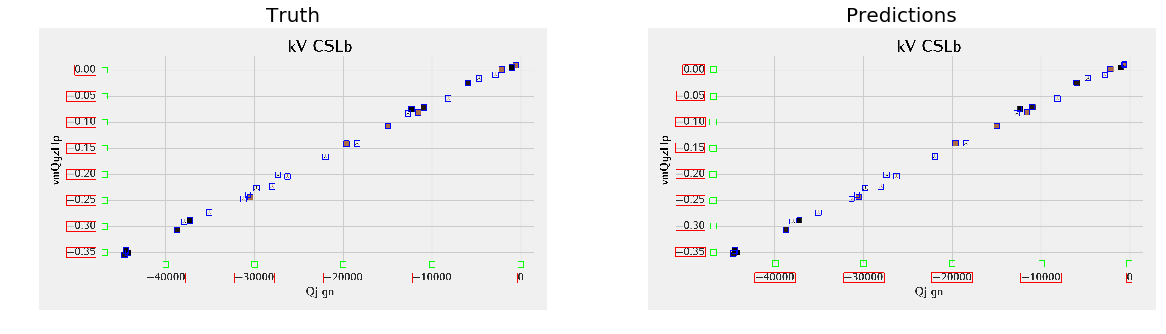

images/4.png


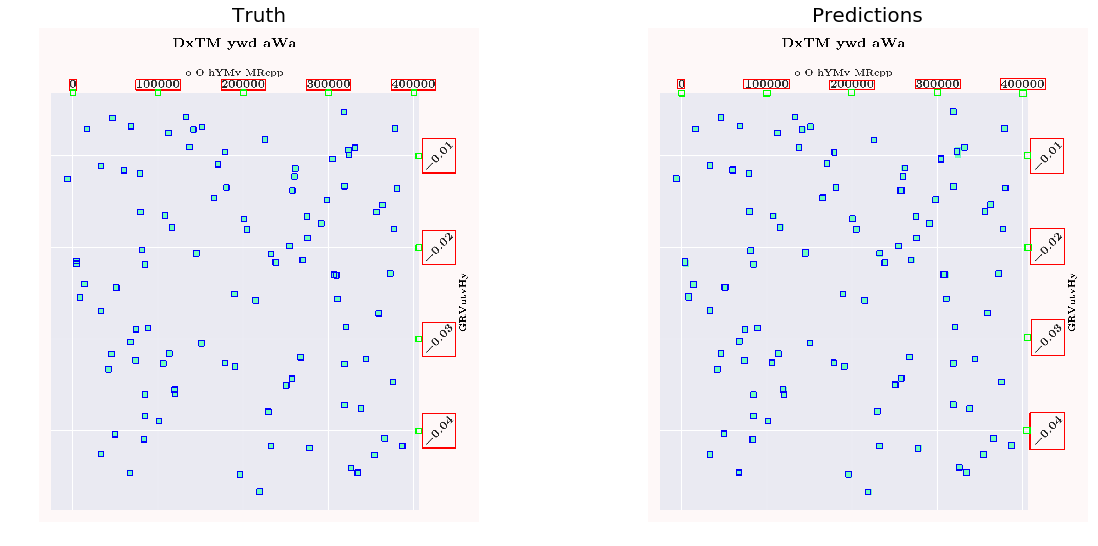

images/5.png


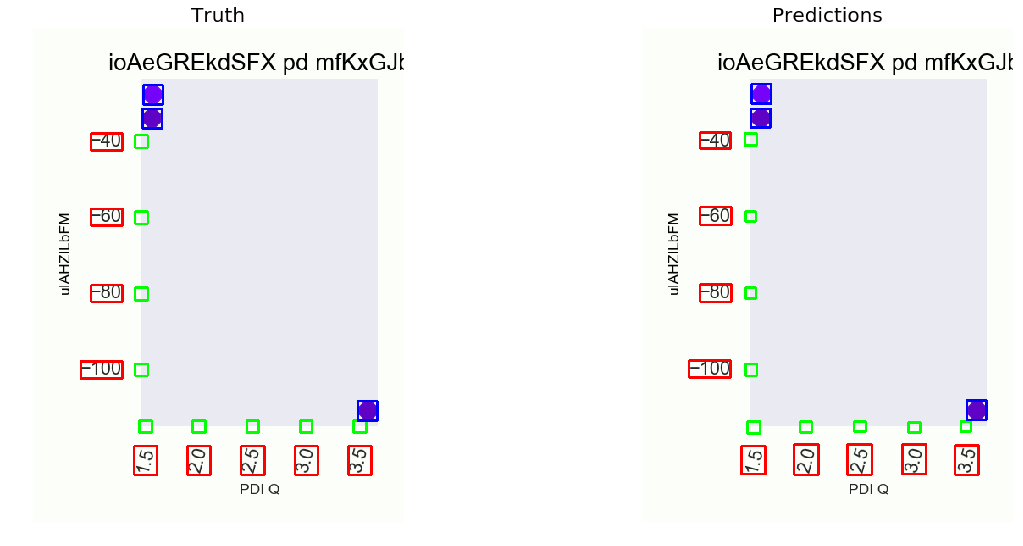

images/6.png


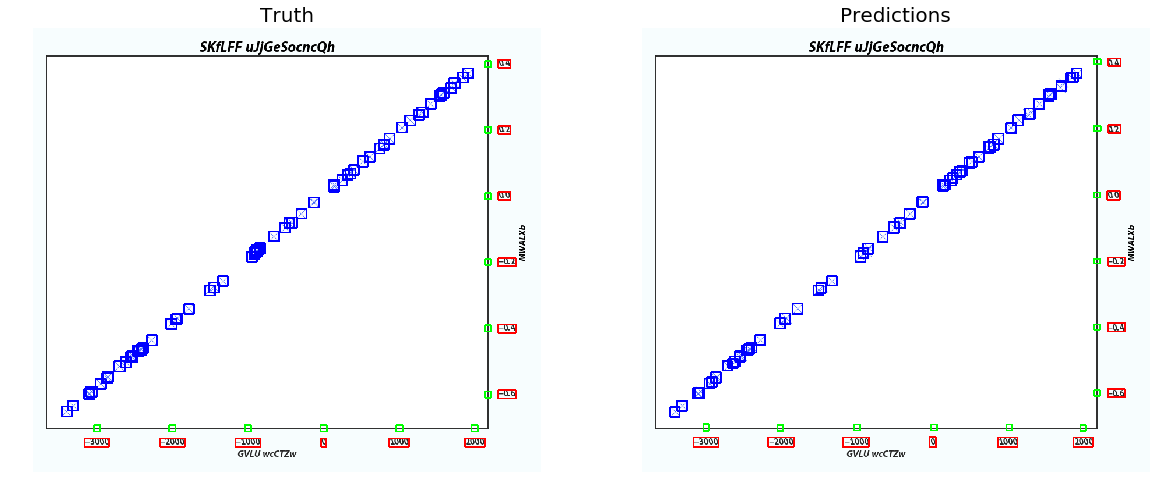

images/7.png


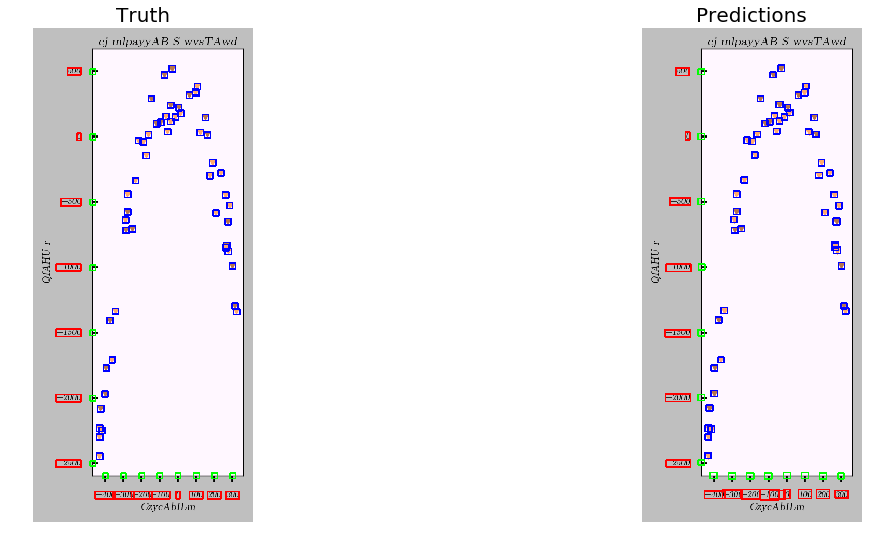

images/8.png


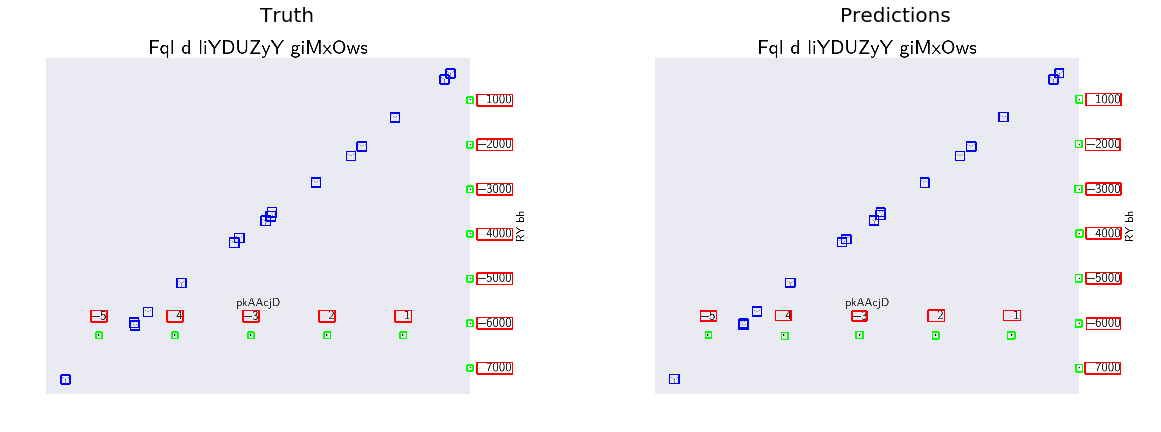

images/9.png


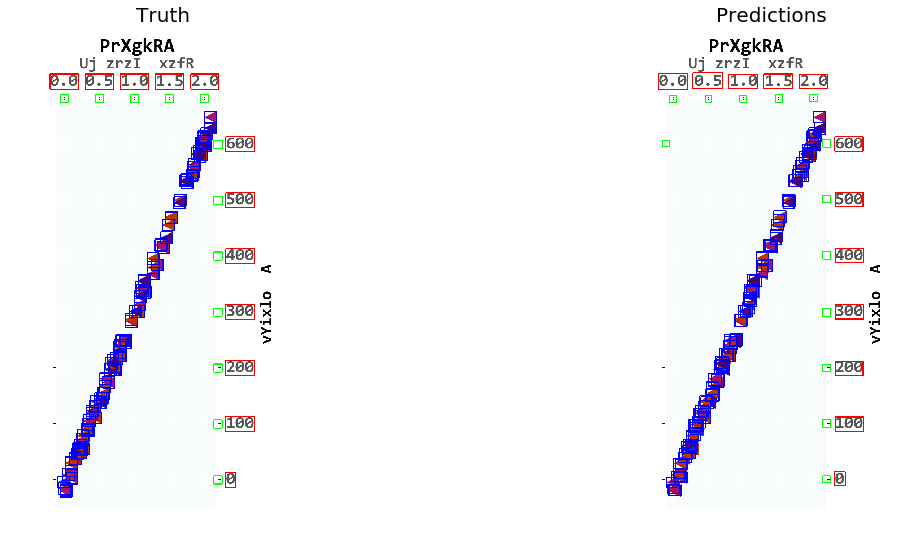

images/10.png


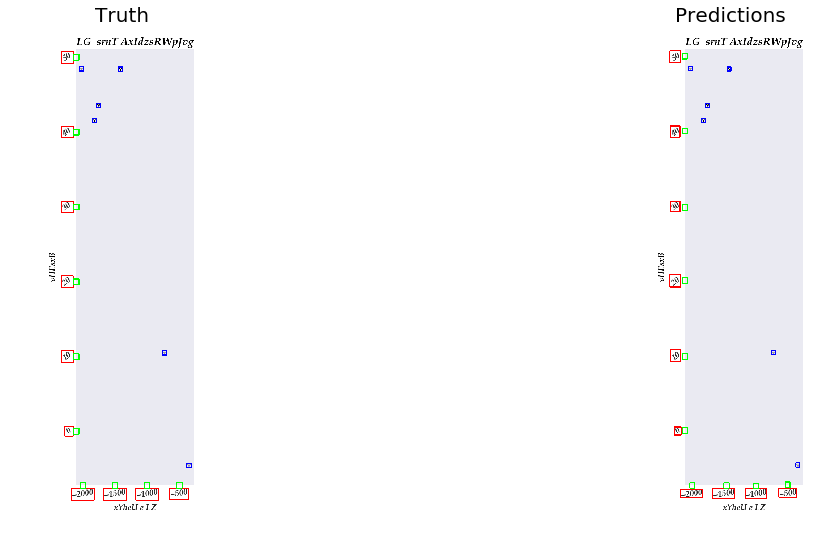

In [5]:
for j in range(len(true_annos_dict["ticks"])):
    
    img = plt_xtr.open_image("./data/plot_test/" + true_annos_dict["ticks"][j].imageName)
    img_true = np.copy(img)
    img_pred = np.copy(img)
    
    for key in true_annos_dict:
        
        for rect_true in true_annos_dict[key][j].rects:
            cv2.rectangle(img_true, (int(rect_true.x1),int(rect_true.y1)), 
                          (int(rect_true.x2),int(rect_true.y2)),
                           plt_xtr.color_dict[key], 2)
            
        for rect_pred in pred_dict[key][j].rects:
            cv2.rectangle(img_pred, (int(rect_pred.x1),int(rect_pred.y1)), 
                          (int(rect_pred.x2),int(rect_pred.y2)),
                           plt_xtr.color_dict[key], 2)
    
    print true_annos_dict["ticks"][j].imageName
    
    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(img_true)
    ax1.axis("off")
    ax1.set_title("Truth", fontsize=20)
    
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(img_pred)
    ax2.axis("off")
    ax2.set_title("Predictions", fontsize=20)
    
    plt.show()

### Applying OCR on the tick values, getting the closest tick mark for each tick value, splitting the X and Y axis, applying RANSAC regression to find the conversion factors and getting points in chart coordinates

In [6]:
pred_dict['labels'] = plt_xtr.get_ocr(pred_dict['labels'], "./data/plot_test/")

pred_dict['labels'] = plt_xtr.get_closest_ticks(pred_dict['labels'], pred_dict['ticks'])

pred_labels_X, pred_labels_Y = plt_xtr.split_labels_XY(pred_dict['labels'])

regressor_x_dict = plt_xtr.get_conversion(pred_labels_X, cat='x')
regressor_y_dict = plt_xtr.get_conversion(pred_labels_Y, cat='y')

df_dict_pred = plt_xtr.predict_points(pred_dict['points'], regressor_x_dict, regressor_y_dict)

### Showing plots and some of the points found in the coordinate system of the chart

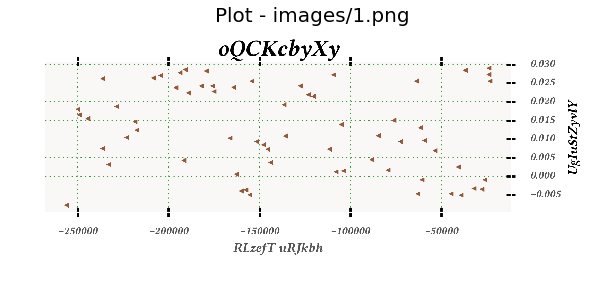

First 10 points detected:


$X_{\text{pred}}$,$Y_{\text{pred}}$
-191161.349627,0.028653
-37456.496296,0.028430
-24239.158007,0.029010
-194145.909886,0.027806
-179649.474343,0.028207
-24452.340882,0.027360
-236782.485013,0.026201
-209068.711180,0.026424
-204805.053668,0.027048
-109512.308260,0.027182


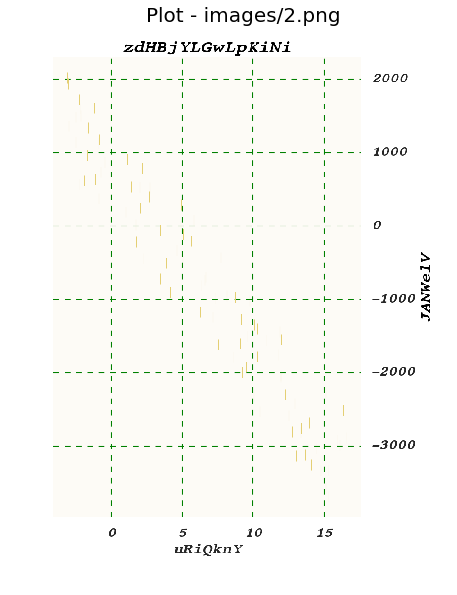

First 10 points detected:


$X_{\text{pred}}$,$Y_{\text{pred}}$
-3.078938,2015.415668
-2.242029,1722.207707
-1.166002,1603.895722
-0.010269,1480.439738
-2.939453,1346.695756
-1.604383,1331.263758
-2.481146,1135.791784
-0.867105,1156.367781
-1.644236,960.895807
1.125537,909.455814


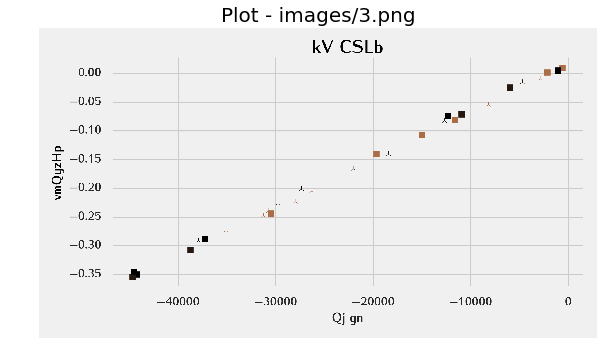

First 10 points detected:


$X_{\text{pred}}$,$Y_{\text{pred}}$
-602.419668,0.010958
-2155.564188,0.001574
-4704.314170,-0.015693
-2792.751684,-0.009312
-6018.513380,-0.024327
-8169.021177,-0.055107
-12430.212553,-0.074251
-10996.540689,-0.070873
-12748.806301,-0.082884
-15018.786754,-0.106908


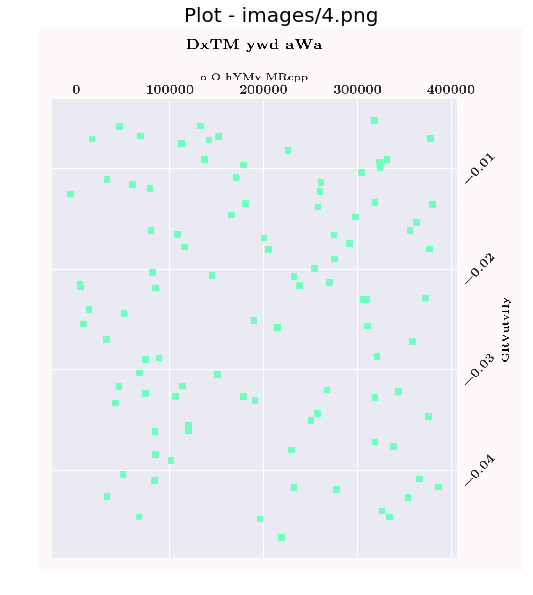

First 10 points detected:


$X_{\text{pred}}$,$Y_{\text{pred}}$
318979.001132,-0.005227
46403.301545,-0.005902
68998.392432,-0.006803
132838.490493,-0.005790
151488.406781,-0.006878
16635.165933,-0.007141
112395.313024,-0.007554
141446.144164,-0.007179
378873.924593,-0.007066
137859.621801,-0.009130


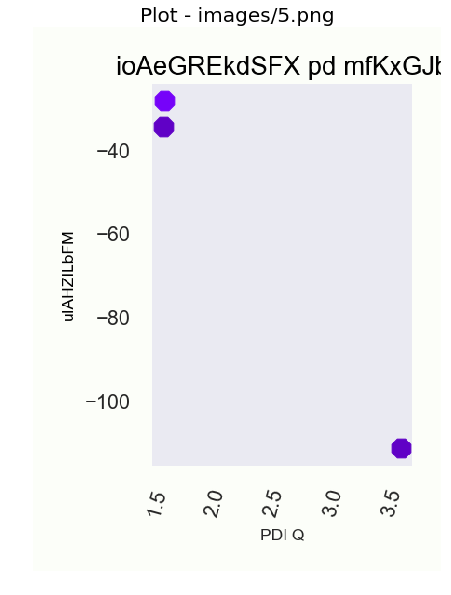

First 10 points detected:


$X_{\text{pred}}$,$Y_{\text{pred}}$
1.579433,-28.170360
1.572200,-34.516988
3.592664,-110.408353


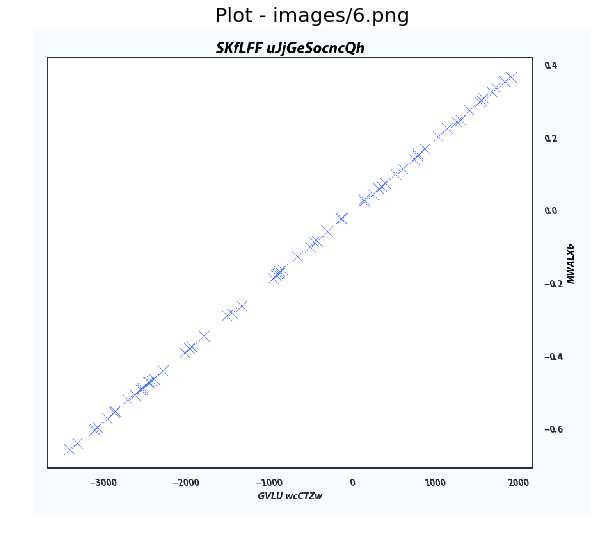

First 10 points detected:


$X_{\text{pred}}$,$Y_{\text{pred}}$
1809.207202,0.353249
1892.978305,0.366279
1525.316241,0.302058
1543.932042,0.303919
1683.550547,0.326257
1395.005636,0.274136
1115.768626,0.224806
1264.695031,0.244352
855.147416,0.168962
1022.689622,0.200607


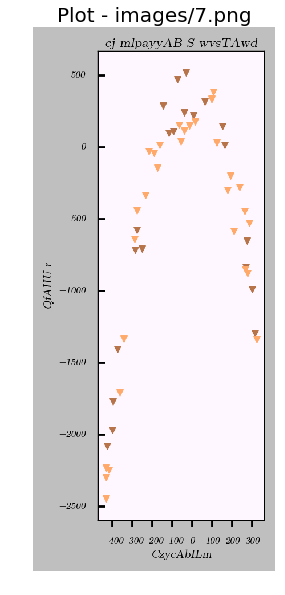

First 10 points detected:


$X_{\text{pred}}$,$Y_{\text{pred}}$
-29.292929,523.934376
-74.747475,473.874291
106.228956,386.927827
-143.771044,292.077140
-39.393939,247.286538
63.299663,315.789812
98.653199,336.867742
-66.329966,160.340074
6.060606,220.939125
16.161616,184.052746


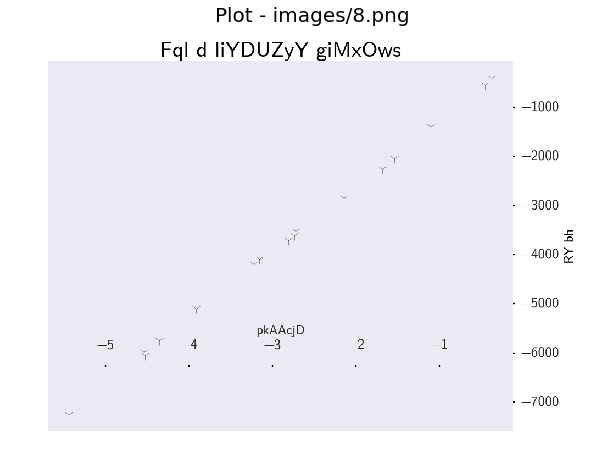

First 10 points detected:


$X_{\text{pred}}$,$Y_{\text{pred}}$
-0.364295,-424.059631
-0.443527,-559.786540
-1.105343,-1403.653839
-1.529464,-2052.782530
-1.678606,-2265.224647
-2.144673,-2861.242810
-2.727257,-3522.173841
-2.727257,-3587.086710
-2.815810,-3711.011279
-3.179343,-4124.093173


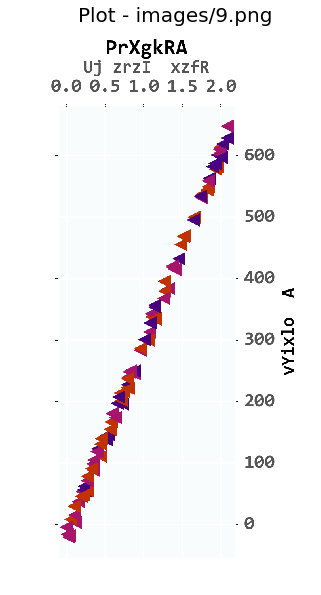

First 10 points detected:


$X_{\text{pred}}$,$Y_{\text{pred}}$
2.080056,647.493211
1.989504,612.544181
2.089845,626.646421
1.930769,579.434574
1.737429,533.449008
1.747219,533.449008
1.644431,497.886837
1.651773,497.273697
1.519617,469.069216
1.480460,454.353835


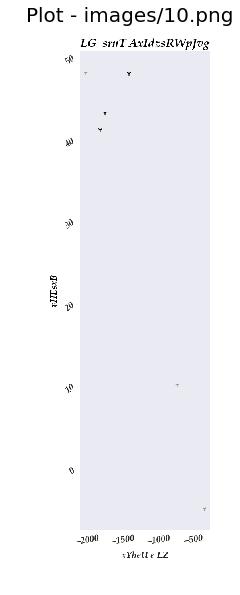

First 10 points detected:


$X_{\text{pred}}$,$Y_{\text{pred}}$
-2046.427085,48.383834
-1431.145992,48.337910
-1769.550593,43.470044
-1840.126954,41.449421
-738.049938,10.451218
-348.975129,-4.565690


In [7]:
for j in range(len(true_annos_dict["ticks"])):
    
    key = true_annos_dict["ticks"][j].imageName

    plot_img = plt_xtr.open_image("./data/plot_test/" + key)
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,1,1)
    ax1.imshow(plot_img)
    ax1.axis("off")
    ax1.set_title("Plot - {}".format(key), fontsize=20)
    plt.show()
    
    print "First 10 points detected:"
    df_pred_display = df_dict_pred[key].copy()
    df_pred_display.columns = [r'$X_{\text{pred}}$', r'$Y_{\text{pred}}$']
    display(HTML(df_pred_display.head(10).to_html(index=False)))

### Evaluting the performance systematically

In [8]:
df_prec_rec = plt_xtr.get_metrics(df_dict_pred, "./data/plot_test/coords.idl", max_dist_perc = 2.0)
df_prec_rec.set_index('image_name').sort_index()

,precision,recall
image_name,,
images/1.png,1.000000,1.000000
images/10.png,1.000000,1.000000
images/2.png,0.988636,0.956044
images/3.png,1.000000,0.965517
images/4.png,1.000000,0.979798
images/5.png,1.000000,1.000000
images/6.png,0.919355,0.919355
images/7.png,1.000000,0.980769
images/8.png,1.000000,1.000000
